## 新能源电动汽车动力电池充电能量预测（四）——缺失数据填充

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
from datetime import date, datetime
from package import utils
from scipy import stats

### 数据导入

In [2]:
# 导入经过异常检测后的数据集合
dataset = pd.read_csv('./energy_predict_data/train_data_filter/3_outlier_detection/predict_data_e_train.csv')
# 数据字段
header = dataset.columns.values.tolist()
# 数据集大小
count = np.max(dataset['vehicle_id'])
# 数据描述
pd.set_option('precision', 2)
dataset.describe()

,vehicle_id,charge_start_time,charge_end_time,charge_duration,mileage,delta_mileage,charge_start_soc,charge_end_soc,charge_delta_soc,charge_start_U,charge_end_U,charge_start_I,charge_end_I,charge_max_temp,charge_min_temp,charge_energy
count,5860.00,5.86e+03,5.86e+03,5860.00,5860.00,5850.00,5853.00,5817.00,5816.00,5860.00,5860.00,5860.00,5860.00,5860.00,5860.00,5.86e+03
mean,5.17,2.02e+13,2.02e+13,3576.89,108324.26,81.67,48.88,70.32,21.35,460.68,439.73,-44.82,-19.69,29.46,15.67,2.34e+01
std,3.06,3.99e+09,3.99e+09,4511.58,31142.88,202.77,30.08,34.48,31.98,103.54,157.18,55.86,40.51,10.69,13.02,2.44e+01
min,1.00,2.02e+13,2.02e+13,10.00,45631.70,-250.20,0.80,0.00,-100.00,252.00,0.00,-202.00,-400.00,-2.00,-7.00,1.00e-03
25%,2.00,2.02e+13,2.02e+13,730.00,83569.40,14.00,25.00,34.00,0.00,345.20,372.50,-64.50,-16.10,21.00,2.00,3.85e+00
50%,5.00,2.02e+13,2.02e+13,2380.00,106180.00,69.50,42.00,86.00,21.00,533.60,394.70,-21.00,-7.70,31.00,15.00,1.65e+01
75%,8.00,2.02e+13,2.02e+13,4559.25,129317.50,115.00,68.00,100.00,44.00,551.30,565.60,-7.50,-1.00,37.00,27.00,3.26e+01
max,10.00,2.02e+13,2.02e+13,42770.00,184014.00,9703.00,100.00,100.00,88.00,595.30,604.80,-0.10,9.00,52.00,44.00,1.10e+02


#### 数据缺失情况

In [3]:
dataset.isnull().sum()

vehicle_id            0
charge_start_time     0
charge_end_time       0
charge_duration       0
mileage               0
delta_mileage        10
charge_start_soc      7
charge_end_soc       43
charge_delta_soc     44
charge_start_U        0
charge_end_U          0
charge_start_I        0
charge_end_I          0
charge_max_temp       0
charge_min_temp       0
charge_energy         1
dtype: int64

#### 每辆车上含有缺失值的数量分布

/Users/Jeremy/miniconda3/envs/test/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


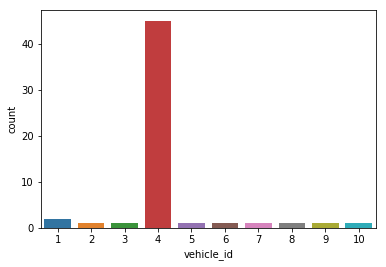

In [4]:
# 缺失数据集
dataset_with_null = dataset[dataset.T.isnull().any()]
null_index_list = dataset_with_null.index.tolist()
for i in range(len(null_index_list)):
    null_index_list[i] = null_index_list[i] - i
sns.countplot(x='vehicle_id', data=dataset_with_null)

>观察1：整体来说，缺失情况不是很严重；只有delta_mileage、charge_start_soc、charge_end_soc、charge_delta_soc、charge_energy这些字段存在缺失。

>观察2：相对来说，第4辆车缺失较多。

>方法：采用聚类思想进行数据填充：选择参与聚类的字段是很重要的，根据第2步特征工程的结论，我们选择charge_duration、delta_mileage、charge_start_soc、charge_delta_soc、charge_start_U、charge_min_temp这些特征信息进行聚类。然后，对含有缺失值记录按照欧式距离寻找距其最近的类，然后用该类中心属性值对缺失值进行填充。

### 数据填充。

#### 获取完美数据集

In [5]:
# 完美数据集
dataset_without_null = dataset[~dataset.T.isnull().any()]

/Users/Jeremy/miniconda3/envs/test/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


((array([-3.67398566, -3.44096839, -3.31265616, ...,  3.31265616,
          3.44096839,  3.67398566]),
  array([  1.00000000e-03,   1.00000000e-03,   2.00000000e-03, ...,
           1.03674000e+02,   1.03722000e+02,   1.09842000e+02])),
 (22.524000401376956, 23.423421533161065, 0.91950082021191804))

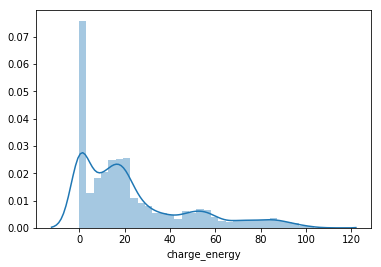

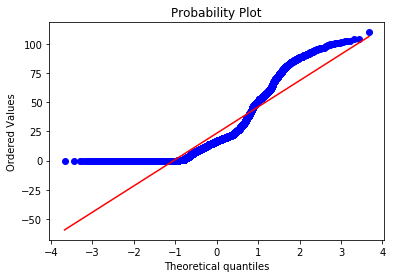

In [6]:
from scipy import stats
fig = plt.figure()
sns.distplot(dataset_without_null['charge_energy']);
fig = plt.figure()
stats.probplot(dataset_without_null['charge_energy'], plot=plt)

#### 使用KMeans对用完美数据集进行聚类

<bound method KMeans.score of KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=3, tol=0.0001, verbose=0)>


/Users/Jeremy/miniconda3/envs/test/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


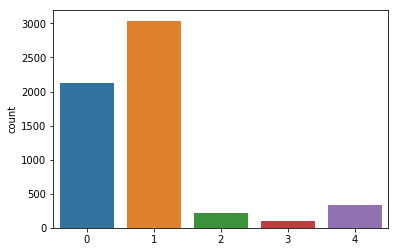

In [7]:
from sklearn.cluster import KMeans
#聚类和填充需要操作的列名
compute_header = ['charge_duration', 'delta_mileage', 'charge_start_soc', 'charge_delta_soc', 'charge_min_temp', 'charge_energy']
cluster_source = dataset_without_null[compute_header]
kmeans = KMeans(n_clusters=5, random_state=3).fit(cluster_source)
cluster = kmeans.cluster_centers_
labels = kmeans.labels_
print(kmeans.score)
sns.countplot(labels)

#### 利用聚类结果进行数据填充

In [8]:
#转化为array
dataset_with_null_values = dataset_with_null[compute_header].values
for i in range(len(dataset_with_null_values)):
    maxD = float('inf')
    maxV = []
    data = dataset_with_null_values[i]
    for center in cluster:
        dis = utils.distance(center, data)
        if dis < maxD:
            maxD = dis
            maxV = center
    dataset_with_null_values[i] = utils.filling(maxV,data)
    

In [9]:
#填充结果覆盖到不完美数据集
dataset_with_null_filled = pd.DataFrame(dataset_with_null_values,columns=compute_header)
dataset_with_null_filled.describe()

,charge_duration,delta_mileage,charge_start_soc,charge_delta_soc,charge_min_temp,charge_energy
count,55.00,55.00,55.00,55.00,55.00,55.00
mean,4438.27,95.14,34.36,33.72,8.69,21.03
std,2259.49,70.84,12.20,15.35,5.14,15.11
min,50.00,9.30,6.40,0.80,1.00,0.08
25%,3960.00,76.90,29.40,38.14,5.00,16.86
50%,4800.00,89.40,33.20,38.14,8.00,20.19
75%,5224.00,102.35,37.00,38.14,11.00,21.74
max,15700.00,573.10,80.40,71.00,27.00,80.50


In [10]:
dataset_with_null_filled['charge_end_soc'] = dataset_with_null_filled['charge_start_soc'] + dataset_with_null_filled['charge_delta_soc']
temp = pd.DataFrame()
for col in compute_header:
    temp[col] = dataset_with_null_filled[col]

for col in list(set(header).difference(set(compute_header))):
    temp[col] = dataset_with_null[col].tolist()

temp['charge_end_soc'] = dataset_with_null_filled['charge_end_soc'].tolist()
temp = temp[header]

# 填充后的完整数据集合
dataset_whole = pd.DataFrame(
    np.insert(dataset_without_null.values, null_index_list, temp.values, axis=0), 
    columns=dataset_without_null.columns)

### 保存完美数据、缺失数据及填充后的完整数据集

In [11]:
dataset_with_null.to_csv("./energy_predict_data/train_data_filter/4_fill_null/not_perfect/unfilled/predict_data_e_train.csv", index=False)
dataset_without_null.to_csv("./energy_predict_data/train_data_filter/4_fill_null/perfect/predict_data_e_train.csv", index=False)
temp.to_csv("./energy_predict_data/train_data_filter/4_fill_null/not_perfect/filled_by_kmeans/predict_data_e_train.csv", index=False)
dataset_whole.to_csv("./energy_predict_data/train_data_filter/4_fill_null/whole/filled_by_kmeans/predict_data_e_train.csv", index=False)

for i in range(1, count+1):
    data_with_null = dataset_with_null[(dataset_with_null['vehicle_id']==i)]
    data_with_null.to_csv("./energy_predict_data/train_data_filter/4_fill_null/not_perfect/unfilled/predict_data_e_train_%d.csv" % i, index=False)
    
    data_without_null = dataset_without_null[(dataset_without_null['vehicle_id']==i)]
    data_without_null.to_csv("./energy_predict_data/train_data_filter/4_fill_null/perfect/predict_data_e_train_%d.csv" % i, index=False)
    
    data_fill_null = temp[(temp['vehicle_id']==i)]
    data_fill_null.to_csv("./energy_predict_data/train_data_filter/4_fill_null/not_perfect/filled_by_kmeans/predict_data_e_train_%d.csv" % i, index=False)
    
    data_whole = dataset_whole[(dataset_whole['vehicle_id']==i)]
    data_whole.to_csv("./energy_predict_data/train_data_filter/4_fill_null/whole/filled_by_kmeans/predict_data_e_train_%d.csv" % i, index=False)
    